In [60]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
warnings.filterwarnings("ignore", message="Workbook contains no default style, apply openpyxl's default")
warnings.simplefilter(action='ignore', category=FutureWarning)



folder_path = 'TothSpreadsheets'

In [2]:
# Function to read all spreadsheets in a folder and extract labels from the first column
def extract_instrument_counts(folder_path):
    instruments_count = {}
    for file_name in os.listdir(folder_path):
        # if starts with 'Toth' and ends with .xlsx
        if file_name.startswith('Toth') and (file_name.endswith('.xlsx') or file_name.endswith('.xls')):
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_excel(file_path)
            labels = df.iloc[2:, 0].tolist()  # Assuming you want to skip the first two rows
            for label in labels:
                instruments_count[label] = instruments_count.get(label, 0) + 1

    # returns a dictionary with labels as keys and their counts as values
    return instruments_count



{nan: 49, 'Jegogan': 94, 'Calung': 99, 'Giying': 76, 'Pemade': 178, 'Kantilan': 146, 'Reyong': 57, 'Trompong': 62, 'Penyacah': 37}


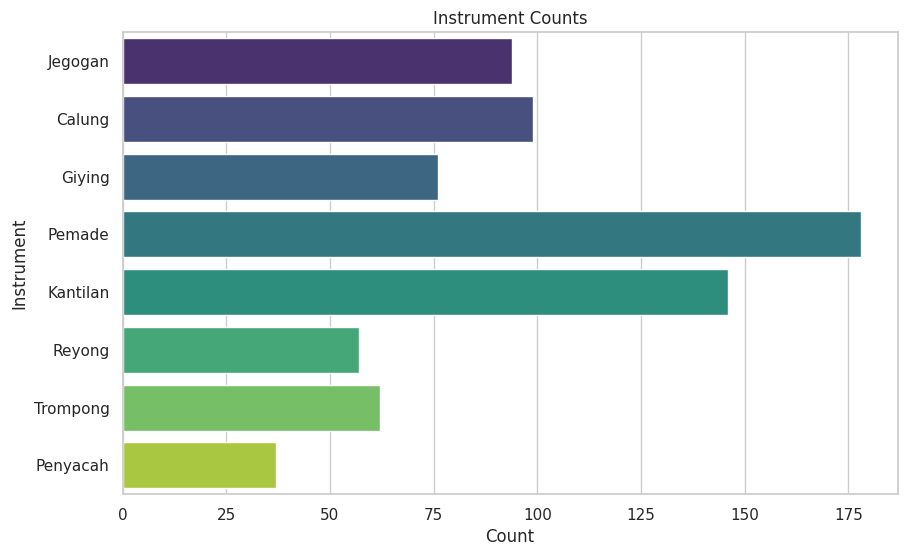

In [3]:
instruments_count = extract_instrument_counts(folder_path)
print(instruments_count)

# plot the counts with seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=list(instruments_count.values()), y=list(instruments_count.keys()), palette="viridis") 
plt.title('Instrument Counts')
plt.xlabel('Count')
plt.ylabel('Instrument')
plt.show()



In [4]:


def classify_pairs(folder_path):
    classification = {}
    for file_name in os.listdir(folder_path):
        if file_name.startswith('Toth') and (file_name.endswith('.xlsx') or file_name.endswith('.xls')):
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_excel(file_path)
            # starting from the 3rd row
            for _, row in df.iloc[2:].iterrows():
                label = row[0]
                value = row[1]
                if label not in classification:
                    classification[label] = {'pengisep': 0, 'pengumbang': 0}
                if value == '+':
                    classification[label]['pengisep'] += 1
                elif value == '-':
                    classification[label]['pengumbang'] += 1

    return classification

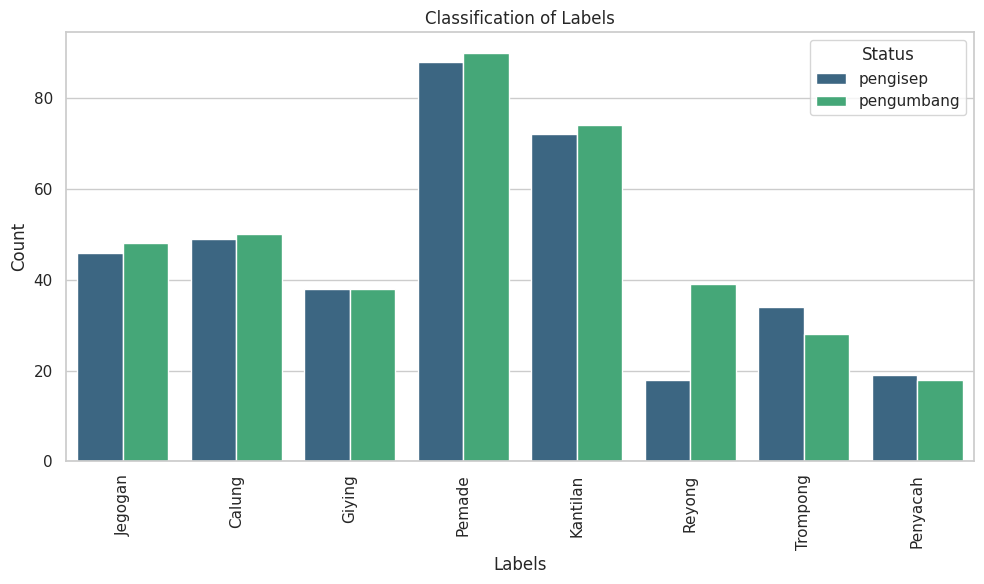

In [5]:
# Classify the labels based on the values in the second column
classification = classify_pairs(folder_path)
#print(classification)

# Convert dictionary to DataFrame for seaborn
data = pd.DataFrame([(label, status, count) for label, status_dict in classification.items() for status, count in status_dict.items()],
                    columns=['Labels', 'Status', 'Count'])

# Plotting the data with seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Labels', y='Count', hue='Status', data=data, palette='viridis')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Classification of Labels')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [15]:

#create a dictornary to store the the following data
pemade_tuning_dict = {}

#iterate and read every file in the folder TothSpreadsheets
for file_name in os.listdir('TothSpreadsheets/'):
    if file_name.startswith('Toth') and (file_name.endswith('.xlsx') or file_name.endswith('.xls')):
        file_path = os.path.join('TothSpreadsheets', file_name)
        df = pd.read_excel(file_path)
       

# # get a signle spreadsheet to test the code
# file_path = 'TothSpreadsheets/Toth01-Peliatan.xlsx'
# df = pd.read_excel(file_path)
# # get the title of the file
# file_name = 'Toth01-Peliatan.xlsx'


    # read the title of the file, take the word after the hyphen and before the format 
    gamelan_name = file_name.split('-')[1].split('.')[0]
    # print(gamelan_name)

    # get the third row of the file and store it in a dictionary and store each one of the 24 first values as keys in a dictionary inside gamelan_name key
    pemade_tuning_dict[gamelan_name] = {}

    # get the header of second row, first column and store as value in pemade_tuning_dict[gamelan_name][regency_name]
    pemade_tuning_dict[gamelan_name]['Regency'] = df.iloc[0, 0]
    # print(pemade_tuning_dict[gamelan_name]['Regency'])

    # - get the third row and store as keys in pemade_tuning_dict[gamelan_name] adding a number in the key as a prefix
    for i in range(23):
        pemade_tuning_dict[gamelan_name][f'{i+1}', df.iloc[2, i+1]] = []

    # take each row of the file that satisfies the condition of having the label 'Pemade' as the first element of the row and store each element as a value to a successive key in pemade_tuning_dict[gamelan_name]
    for _, row in df.iterrows():
        if row[0] == 'Pemade':
            for i in range(23):
                pemade_tuning_dict[gamelan_name][f'{i+1}', df.iloc[2, i+1]].append(row[i+1])


# for each dictionary in pemade_tuning_dict remove the key and value pairs if the value only has nan values
for gamelan_name, gamelan_dict in pemade_tuning_dict.items():
    for key, value in list(gamelan_dict.items()):
        if all(pd.isna(val) for val in value):
            del pemade_tuning_dict[gamelan_name][key]

# print the dictionary
print(pemade_tuning_dict)












{'KuaDuahUbung': {'Regency': 'Badung', ('1', nan): ['-', '-', '+', '+'], ('9', 'dong'): [291.6, 291.6, 296.7, 298.8], ('10', 'deng'): [319, 319.5, 324.90000000000003, 327.40000000000003], ('11', 'dung'): [405.6, 407.90000000000003, 412.70000000000005, 414.8], ('12', 'dang'): [430.70000000000005, 431.70000000000005, 436.5, 435.70000000000005], ('13', 'ding'): [555, 556.6, 561.1, 560.8000000000001], ('14', 'dong'): [587.7, 589, 595.2, 597.6], ('15', 'deng'): [659.6, 663.5, 668.1, 669.2], ('16', 'dung'): [810.2, 812.6, 817.3000000000001, 820.6], ('17', 'dang'): [854.5, 858.9000000000001, 860.4000000000001, 860.9000000000001], ('18', 'ding'): [1094.7, 1096.6000000000001, 1099.2, 1101.1000000000001]}, 'Getas': {'Regency': 'Gianyar', ('1', nan): ['-', '-', '+', '+'], ('9', 'dong'): [265.3, 265.40000000000003, 271.2, 271.6], ('10', 'deng'): [293.3, 292.6, 299.3, 299.5], ('11', 'dung'): [354.90000000000003, 354.5, 360.70000000000005, 360.5], ('12', 'dang'): [380.6, 380.6, 387, 387.3], ('13', '

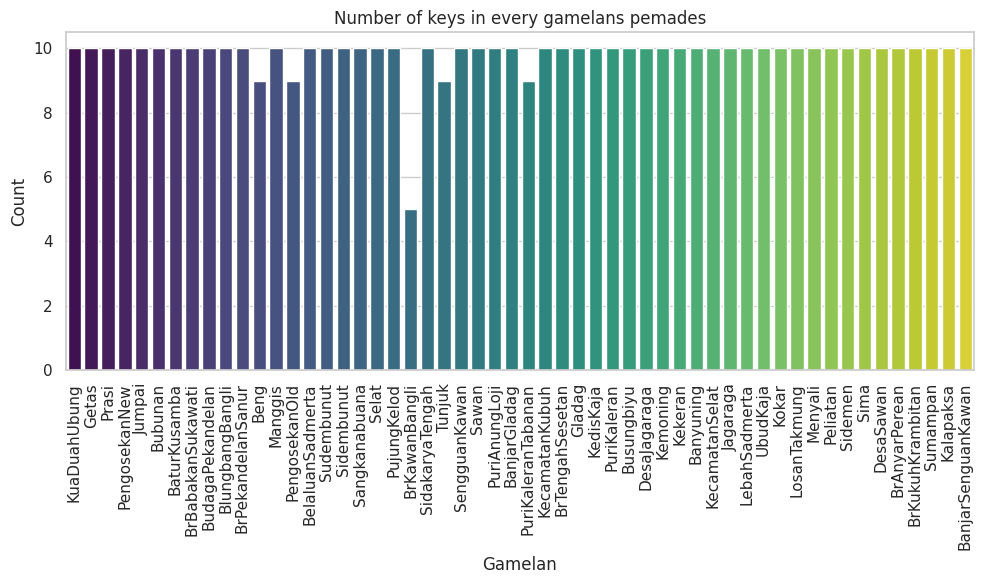

In [19]:
# create a dictionary that stores the number of keys minus 1 for each gamelan in pemade_tuning_dict
pemade_tuning_dict_count = {}
for gamelan_name, tuning_dict in pemade_tuning_dict.items():
    pemade_tuning_dict_count[gamelan_name] = len(tuning_dict) - 2

# print(pemade_tuning_dict_count)

# plot with seaborn the number of keys minus 1 for each gamelan in pemade_tuning_dict
data = pd.DataFrame({'Gamelan': list(pemade_tuning_dict_count.keys()), 'Count': list(pemade_tuning_dict_count.values())})
plt.figure(figsize=(10, 6))

# plot the color correlated on the number of keys minus 1
sns.barplot(x='Gamelan', y='Count', data=data, palette='viridis')
plt.xlabel('Gamelan')
plt.ylabel('Count')
plt.title('Number of keys in every gamelans pemades')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



{'Regency': 54, ('9', 'dong'): 50, ('10', 'deng'): 54, ('11', 'dung'): 54, ('12', 'dang'): 54, ('13', 'ding'): 53, ('14', 'dong'): 53, ('15', 'deng'): 53, ('16', 'dung'): 53, ('17', 'dang'): 53, ('18', 'ding'): 53, ('8', 'ding'): 1}


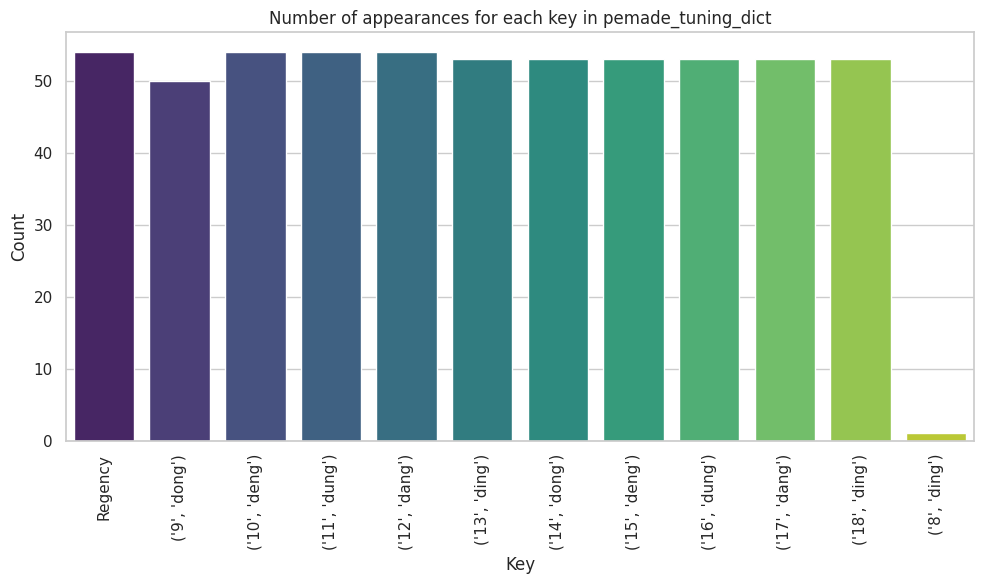

In [20]:
# count the apearence of each key, regardless the number of values, in pemade_tuning_dict. exclude key one
pemade_tuning_dict_appearances = {}
for gamelan_name, tuning_dict in pemade_tuning_dict.items():
    for key, value in tuning_dict.items():
        if key[0] != '1':
            if key[0] != 'Regency':
                if key not in pemade_tuning_dict_appearances:
                    pemade_tuning_dict_appearances[key] = 0
                pemade_tuning_dict_appearances[key] += 1

print(pemade_tuning_dict_appearances)

# plot with seaborn the number of appearances for each key in pemade_tuning_dict
data = pd.DataFrame({'Key': list(pemade_tuning_dict_appearances.keys()), 'Count': list(pemade_tuning_dict_appearances.values())})
plt.figure(figsize=(10, 6))
sns.barplot(x='Key', y='Count', data=data, palette='viridis')
plt.xlabel('Key')
plt.ylabel('Count')
plt.title('Number of appearances for each key in pemade_tuning_dict')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [215]:
# for each gamelan in pemade_tuning_dict, create a dataframe and plot a bar chart

# for gamelan_name, tuning_dict in pemade_tuning_dict.items():
#     df = pd.DataFrame(tuning_dict)
#     df.plot(kind='bar', figsize=(10, 6))
#     plt.xlabel('Pemade')
#     plt.ylabel('Frequency')
#     plt.title(f'Pemade Tuning in {gamelan_name}')
#     plt.xticks(rotation=0)
#     plt.tight_layout()
#     plt.show()


,Region,ding3,dong3,deng3,dung3,dang3,ding4
0,Badung,546.815625,586.790625,652.893750,808.662500,866.509375,1101.512500
1,Bangli,588.712500,641.012500,705.975000,902.987500,981.575000,1212.162500
2,Buleleng,544.816129,585.712903,646.096774,814.619355,871.183871,1106.645161
3,Gianyar,545.788889,587.402778,648.211111,804.033333,865.136111,1101.719444
4,Karangasem,504.200000,540.722222,596.733333,740.355556,797.222222,1006.855556
5,Klungklung,488.204000,527.064000,577.928000,724.920000,783.740000,996.416000
6,Tabanan,518.860000,557.125000,616.630000,763.815000,821.745000,1041.060000


{'Badung': 10, 'Gianyar': 11, 'Karangasem': 5, 'Klungklung': 7, 'Buleleng': 12, 'Bangli': 3, 'Tabanan': 6}


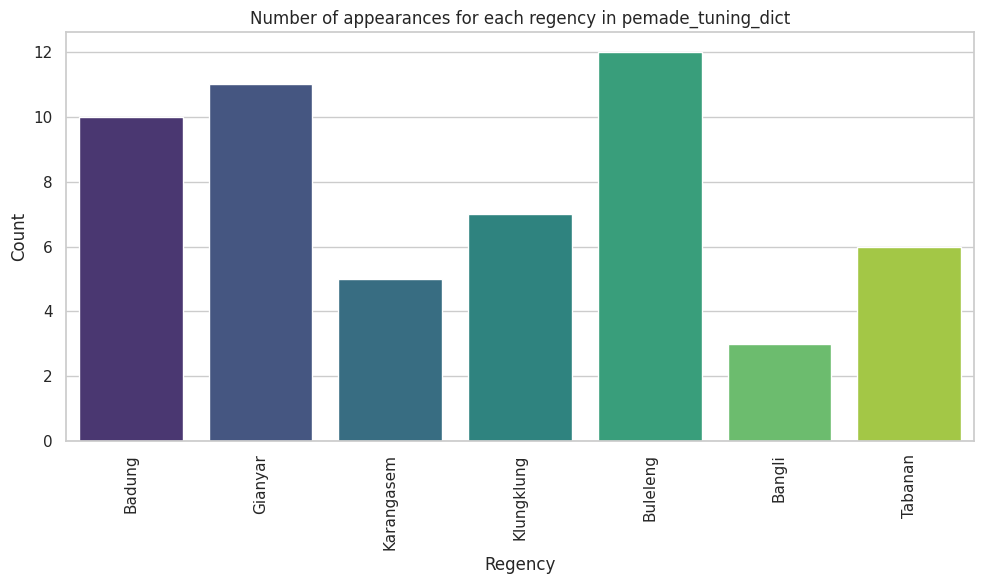

In [25]:
# Count times of each regency in pemade_tuning_dict
pemade_tuning_dict_regency = {}
for gamelan_name, tuning_dict in pemade_tuning_dict.items():
    regency = tuning_dict['Regency']
    if regency not in pemade_tuning_dict_regency:
        pemade_tuning_dict_regency[regency] = 0
    pemade_tuning_dict_regency[regency] += 1

print(pemade_tuning_dict_regency)

# plot with seaborn the number of appearances for each regency in pemade_tuning_dict
data = pd.DataFrame({'Regency': list(pemade_tuning_dict_regency.keys()), 'Count': list(pemade_tuning_dict_regency.values())})
plt.figure(figsize=(10, 6))
sns.barplot(x='Regency', y='Count', data=data, palette='viridis')
plt.xlabel('Regency')
plt.ylabel('Count')
plt.title('Number of appearances for each regency in pemade_tuning_dict')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

    

In [67]:
# create 7 dictionaries to store the data of the 7 regencies
pemade_tuning_dict_gianyar = {}
pemade_tuning_dict_tabanan = {}
pemade_tuning_dict_klungkung = {}
pemade_tuning_dict_bangli = {}
pemade_tuning_dict_karangasem = {}
pemade_tuning_dict_badung = {}
pemade_tuning_dict_buleleng = {}

# iterate through pemade_tuning_dict and store the data in the respective dictionary
for gamelan_name, tuning_dict in pemade_tuning_dict.items():
    regency = tuning_dict['Regency']
    if regency == 'Gianyar':
        pemade_tuning_dict_gianyar[gamelan_name] = tuning_dict
    elif regency == 'Tabanan':
        pemade_tuning_dict_tabanan[gamelan_name] = tuning_dict
    elif regency == 'Klungkung':
        pemade_tuning_dict_klungkung[gamelan_name] = tuning_dict
    elif regency == 'Bangli':
        pemade_tuning_dict_bangli[gamelan_name] = tuning_dict
    elif regency == 'Karangasem':
        pemade_tuning_dict_karangasem[gamelan_name] = tuning_dict
    elif regency == 'Badung':
        pemade_tuning_dict_badung[gamelan_name] = tuning_dict
    elif regency == 'Buleleng':
        pemade_tuning_dict_buleleng[gamelan_name] = tuning_dict


def distribute_values(regency_dict):
    pengisep_scales = []
    pengumbang_scales = []
    
    for key, value in regency_dict.items():
        lists_list = []
        pengisep_values = []
        pengumbang_values = []
        

        for key, value in value.items():
            
            if key[0] == '1' or key[0] == '13' or key[0] == '14' or key[0] == '15' or key[0] == '16' or key[0] == '17' or key[0] == '18':
                lists_list.append(value)


        for i in range(len(lists_list[0])):
        
            if lists_list[0][i] == '-':
                for j in range(len(lists_list)-1):
                    pengumbang_values.append(lists_list[j+1][i])
                pengumbang_scales.append(list(pengumbang_values))
                pengumbang_values = []

            elif lists_list[0][i] == '+':
                for j in range(len(lists_list)-1):
                    pengisep_values.append(lists_list[j+1][i])
                pengisep_scales.append(list(pengisep_values))
                pengisep_values = []

    
    return pengisep_scales, pengumbang_scales
    return lists_list

# print in a nice format pengisep and pengumbang scales for each regency
print('Gianyar')
pengisep_gianyar, pengumbang_gianyar = distribute_values(pemade_tuning_dict_gianyar)
print(pengisep_gianyar)
print(pengumbang_gianyar)

print('Tabanan')
pengisep_tabanan, pengumbang_tabanan = distribute_values(pemade_tuning_dict_tabanan)
print(pengisep_tabanan)
print(pengumbang_tabanan)

print('Klungkung')
pengisep_klungkung, pengumbang_klungkung = distribute_values(pemade_tuning_dict_klungkung)
print(pengisep_klungkung)
print(pengumbang_klungkung)

print('Bangli')
pengisep_bangli, pengumbang_bangli = distribute_values(pemade_tuning_dict_bangli)
print(pengisep_bangli)
print(pengumbang_bangli)

print('Karangasem')
pengisep_karangasem, pengumbang_karangasem = distribute_values(pemade_tuning_dict_karangasem)
print(pengisep_karangasem)
print(pengumbang_karangasem)

print('Badung')
pengisep_badung, pengumbang_badung = distribute_values(pemade_tuning_dict_badung)
print(pengisep_badung)
print(pengumbang_badung)

print('Buleleng')
pengisep_buleleng, pengumbang_buleleng = distribute_values(pemade_tuning_dict_buleleng)
print(pengisep_buleleng)
print(pengumbang_buleleng)



Gianyar
[[494.70000000000005, 537, 593.8000000000001, 715.6, 767.9000000000001, 983.2], [494.5, 537, 593.8000000000001, 716, 767.9000000000001, 982.6], [587.3000000000001, 632, 694.8000000000001, 863.9000000000001, 938.3000000000001, 1178.1000000000001], [588, 630.6, 695.2, 865.9000000000001, 938.8000000000001, 1176.7], [568.3000000000001, 607.7, 674.3000000000001, 835.4000000000001, 895.4000000000001, 1156.5], [542, 588.7, 650.2, 800, 863.9000000000001, 1117.7], [542.3000000000001, 589, 650.2, 800.5, 864.9000000000001, 1117.7], [541.7, 580.9, 632.8000000000001, 778.1, 836.9000000000001, 1085.3], [541.7, 581.3000000000001, 633.1, 777.2, 837.4000000000001, 1085.3], [522.9, 562.4, 624.4000000000001, 763.4000000000001, 821.1, 1051.3], [522.3000000000001, 560.8000000000001, 624.1, 763, 819.6, 1049.5], [538.3000000000001, 586.3000000000001, 653.9000000000001, 807.9000000000001, 858.4000000000001, 1079.7], [539.2, 586, 653.9000000000001, 807.4000000000001, 858.4000000000001, 1080.3], [538.30

In [74]:
# compute the distances in cents
def compute_distance(tone_a, tone_b):
    distance_in_cents = 1200 * np.log2(tone_b / tone_a)
    return distance_in_cents

def compute_distances_scale(scale):
    distances = []
    for i in range(len(scale) - 1):
        tone_a = scale[i]
        tone_b = scale[i + 1]
        d = compute_distance(tone_a, tone_b)
        distances.append(d)
    return distances

for i in range(len(pengisep_gianyar)):
    # compute the distances for each scale and put into a list of lists
    distances_pengisep_gianyar = [compute_distances_scale(scale) for scale in pengisep_gianyar]

for i in range(len(pengumbang_gianyar)):
    distances_pengumbang_gianyar = [compute_distances_scale(scale) for scale in pengumbang_gianyar]

for i in range(len(pengisep_tabanan)):
    distances_pengisep_tabanan = [compute_distances_scale(scale) for scale in pengisep_tabanan]

for i in range(len(pengumbang_tabanan)):
    distances_pengumbang_tabanan = [compute_distances_scale(scale) for scale in pengumbang_tabanan]

for i in range(len(pengisep_klungkung)):
    distances_pengisep_klungkung = [compute_distances_scale(scale) for scale in pengisep_klungkung]

for i in range(len(pengumbang_klungkung)):
    distances_pengumbang_klungkung = [compute_distances_scale(scale) for scale in pengumbang_klungkung]

for i in range(len(pengisep_bangli)):
    distances_pengisep_bangli = [compute_distances_scale(scale) for scale in pengisep_bangli]  

for i in range(len(pengumbang_bangli)):
    distances_pengumbang_bangli = [compute_distances_scale(scale) for scale in pengumbang_bangli]  

for i in range(len(pengisep_karangasem)):
    distances_pengisep_karangasem = [compute_distances_scale(scale) for scale in pengisep_karangasem]

for i in range(len(pengumbang_karangasem)):
    distances_pengumbang_karangasem = [compute_distances_scale(scale) for scale in pengumbang_karangasem]

for i in range(len(pengisep_badung)):
    distances_pengisep_badung = [compute_distances_scale(scale) for scale in pengisep_badung]

for i in range(len(pengumbang_badung)):
    distances_pengumbang_badung = [compute_distances_scale(scale) for scale in pengumbang_badung]

for i in range(len(pengisep_buleleng)):
    distances_pengisep_buleleng = [compute_distances_scale(scale) for scale in pengisep_buleleng]

for i in range(len(pengumbang_buleleng)):
    distances_pengumbang_buleleng = [compute_distances_scale(scale) for scale in pengumbang_buleleng]

# print the distances
print('Gianyar')
print(distances_pengisep_gianyar)
print(distances_pengumbang_gianyar)

print('Tabanan')
print(distances_pengisep_tabanan)
print(distances_pengumbang_tabanan)

# print('Klungkung')
# print(distances_pengisep_klungkung)
# print(distances_pengumbang_klungkung)

print('Bangli')
print(distances_pengisep_bangli)
print(distances_pengumbang_bangli)

print('Karangasem')
print(distances_pengisep_karangasem)
print(distances_pengumbang_karangasem)

print('Badung')
print(distances_pengisep_badung)
print(distances_pengumbang_badung)

print('Buleleng')
print(distances_pengisep_buleleng)
print(distances_pengumbang_buleleng)



Gianyar
[[142.04182645698188, 174.0660061366568, 323.01155287830323, 122.11807249066672, 427.87976149423747], [142.74188067156211, 174.0660061366568, 323.97899299795586, 121.15063237101405, 426.82294954826517], [126.99230468044512, 164.00783477511314, 377.1198841006608, 143.0219293935727, 394.00900011835887], [121.09081795152956, 168.84349455727875, 380.12680826348844, 139.94090338703563, 391.0281657247214], [116.04789179247607, 180.03756693962305, 370.89185500165695, 120.07820968890185, 442.99325114401006], [143.0877312858173, 172.0211140531291, 358.93973276607727, 133.03718895862784, 445.9161354192973], [143.01175644313682, 171.13910636703957, 360.0214160559161, 133.9583217749325, 443.91331931315415], [120.95488685942881, 148.15172394265832, 357.84717583782646, 126.11960136447904, 449.96008415386746], [122.14658131300003, 147.78058438985784, 355.0230064342924, 129.1572205859493, 448.92607943516043], [126.07382907083274, 181.04873148644867, 347.96237908517907, 126.1424986446652, 427.8

In [75]:
# compute the mean of the distances for each regency
mean_distances_pengisep_gianyar = [np.mean([sublist[i] for sublist in distances_pengisep_gianyar]) for i in range(len(distances_pengisep_gianyar[0]))]
mean_distances_pengumbang_gianyar = [np.mean([sublist[i] for sublist in distances_pengumbang_gianyar]) for i in range(len(distances_pengumbang_gianyar[0]))]

mean_distances_pengisep_tabanan = [np.mean([sublist[i] for sublist in distances_pengisep_tabanan]) for i in range(len(distances_pengisep_tabanan[0]))]
mean_distances_pengumbang_tabanan = [np.mean([sublist[i] for sublist in distances_pengumbang_tabanan]) for i in range(len(distances_pengumbang_tabanan[0]))]

#mean_distances_pengisep_klungkung = [np.mean([sublist[i] for sublist in distances_pengisep_klungkung]) for i in range(len(distances_pengisep_klungkung[0]))]
# mean_distances_pengumbang_klungkung = [np.mean([sublist[i] for sublist in distances_pengumbang_klungkung]) for i in range(len(distances_pengumbang_klungkung[0]))]

mean_distances_pengisep_bangli = [np.mean([sublist[i] for sublist in distances_pengisep_bangli]) for i in range(len(distances_pengisep_bangli[0]))]
mean_distances_pengumbang_bangli = [np.mean([sublist[i] for sublist in distances_pengumbang_bangli]) for i in range(len(distances_pengumbang_bangli[0]))]

mean_distances_pengisep_karangasem = [np.mean([sublist[i] for sublist in distances_pengisep_karangasem]) for i in range(len(distances_pengisep_karangasem[0]))]
mean_distances_pengumbang_karangasem = [np.mean([sublist[i] for sublist in distances_pengumbang_karangasem]) for i in range(len(distances_pengumbang_karangasem[0]))]

mean_distances_pengisep_badung = [np.mean([sublist[i] for sublist in distances_pengisep_badung]) for i in range(len(distances_pengisep_badung[0]))]
mean_distances_pengumbang_badung = [np.mean([sublist[i] for sublist in distances_pengumbang_badung]) for i in range(len(distances_pengumbang_badung[0]))]

mean_distances_pengisep_buleleng = [np.mean([sublist[i] for sublist in distances_pengisep_buleleng]) for i in range(len(distances_pengisep_buleleng[0]))]
mean_distances_pengumbang_buleleng = [np.mean([sublist[i] for sublist in distances_pengumbang_buleleng]) for i in range(len(distances_pengumbang_buleleng[0]))]


# print the mean distances
print('Gianyar')
print(mean_distances_pengisep_gianyar)
print(mean_distances_pengumbang_gianyar)

print('Tabanan')
print(mean_distances_pengisep_tabanan)
print(mean_distances_pengumbang_tabanan)

print('Klungkung')
# print(mean_distances_pengisep_klungkung)
# print(mean_distances_pengumbang_klungkung)

print('Bangli')
print(mean_distances_pengisep_bangli)
print(mean_distances_pengumbang_bangli)

print('Karangasem')
print(mean_distances_pengisep_karangasem)
print(mean_distances_pengumbang_karangasem)

print('Badung')
print(mean_distances_pengisep_badung)
print(mean_distances_pengumbang_badung)

print('Buleleng')
print(mean_distances_pengisep_buleleng)
print(mean_distances_pengumbang_buleleng)








                



IndexError: list index out of range

NameError: name 'mean_distances_pengisep_klungkung' is not defined

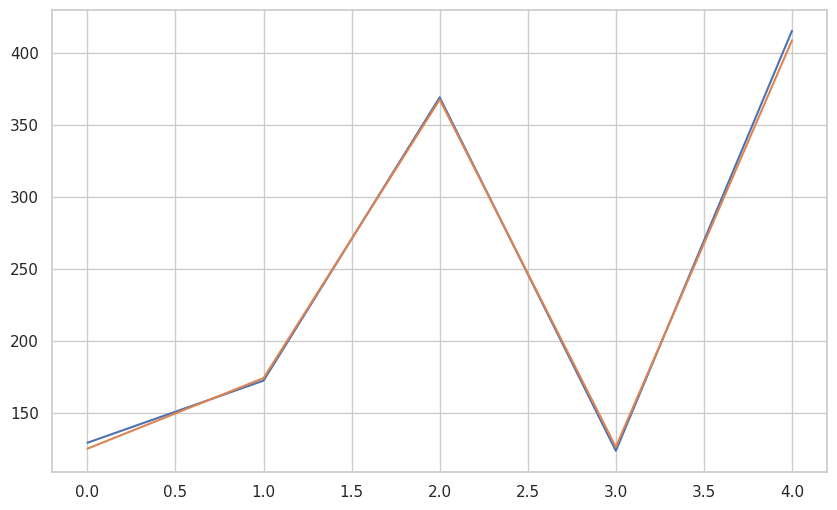

In [76]:
# plot the mean distances for each regency
plt.figure(figsize=(10, 6))
plt.plot(mean_distances_pengisep_gianyar, label='Gianyar')
plt.plot(mean_distances_pengisep_tabanan, label='Tabanan')
plt.plot(mean_distances_pengisep_klungkung, label='Klungkung')
plt.plot(mean_distances_pengisep_bangli, label='Bangli')
plt.plot(mean_distances_pengisep_karangasem, label='Karangasem')
plt.plot(mean_distances_pengisep_badung, label='Badung')
plt.plot(mean_distances_pengisep_buleleng, label='Buleleng')
plt.xlabel('Pemade')
plt.ylabel('Mean distance in cents')
plt.title('Mean distances for pengisep scales')
plt.legend()
plt.tight_layout()
plt.show()



NameError: name 'mean_distances_pengumbang_klungkung' is not defined

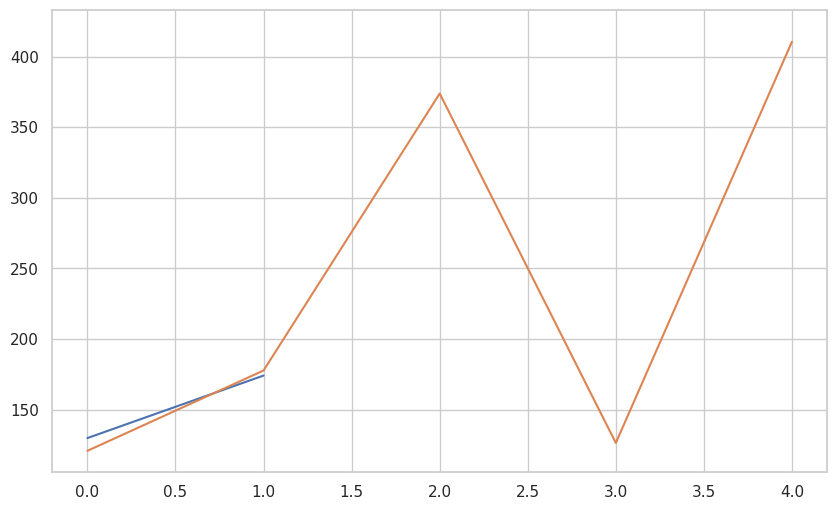

In [77]:
plt.figure(figsize=(10, 6))
plt.plot(mean_distances_pengumbang_gianyar, label='Gianyar')
plt.plot(mean_distances_pengumbang_tabanan, label='Tabanan')
plt.plot(mean_distances_pengumbang_klungkung, label='Klungkung')
plt.plot(mean_distances_pengumbang_bangli, label='Bangli')
plt.plot(mean_distances_pengumbang_karangasem, label='Karangasem')
plt.plot(mean_distances_pengumbang_badung, label='Badung')
plt.plot(mean_distances_pengumbang_buleleng, label='Buleleng')
plt.xlabel('Pemade')
plt.ylabel('Mean distance in cents')
plt.title('Mean distances for pengumbang scales')
plt.legend()
plt.tight_layout()
plt.show()